## 範例
參考 `train.py` 實現的訓練模型程式碼範例


In [1]:
import os
# if not os.path.exists("model_data/yolo.h5"):
    # 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
#     print("Model doesn't exist, downloading...")
#     os.system("wget https://pjreddie.com/media/files/yolov3.weights")
#     print("Converting yolov3.weights to yolo.h5...")
#     os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
# else:
#     print("Model exist")

以下的程式碼負責把下載下來的 Pascal VOC 資料集轉換為訓練模型時需要的格式，直接引用 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py ，調整了一部分程式碼，讓我們只 sample 前 100 張圖片來做示範，在 colab 中會花一些時間跑完

In [ ]:
# 將資料集切割為：train, val, trainval, test
# 切完後再使用voc_使用voc_annotation將xml轉成yoloe格式
import os
import random

trainval_percent = 0.1
train_percent = 0.9
xmlfilepath = 'Data/Raccoon/Annotations'
txtsavepath = 'Data/Raccoon/ImageSets/Main'
total_xml = os.listdir(xmlfilepath)

num = len(total_xml)
list = range(num)
tv = int(num * trainval_percent)
tr = int(tv * train_percent)
trainval = random.sample(list, tv)
train = random.sample(trainval, tr)

ftrainval = open('Data/Raccoon/ImageSets/Main/Raccoon_trainval.txt', 'w')
ftest = open('Data/Raccoon/ImageSets/Main/Raccoon_test.txt', 'w')
ftrain = open('Data/Raccoon/ImageSets/Main/Raccoon_train.txt', 'w')
fval = open('Data/Raccoon/ImageSets/Main/Raccoon_val.txt', 'w')

for i in list:
    name = total_xml[i][:-4] + '\n'
    if i in trainval:
        ftrainval.write(name)
        if i in train:
            ftest.write(name)
        else:
            fval.write(name)
    else:
        ftrain.write(name)

ftrainval.close()
ftrain.close()
fval.close()
ftest.close()

In [ ]:
# if not os.path.exists("2007_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
if not os.path.exists("Kaggle_train.txt"):
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    sets=[('2020', 'train'), ('2020', 'val')]
#     sets=[('100', 'train'), ('100', 'trainval')]


    # Pascal VOC 的資料類別
#     classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    classes = ["kangaroo", "raccoon"]

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(year, image_id, list_file):
        in_file = open('Data/VOC%s/Annotations/%s.xml'%(year, image_id), encoding='utf-8')
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
            difficult = obj.find('difficult').text
            cls = obj.find('name').text
            if cls not in classes or int(difficult)==1:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find('bndbox')
            b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
            list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    wd = "."

    for year, image_set in sets:
        image_ids = open('Data/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
        annotation_path = '%s_%s.txt'%(year, image_set)
        list_file = open(annotation_path, 'w')
        print("save annotation at %s" % annotation_path)
        for image_id in image_ids: # 只處理 100 張圖片來做範例
            list_file.write('%s/Data/VOC%s/Images/%s.jpg'%(wd, year, image_id))
            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        list_file.close()

In [2]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
import keras
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

Using TensorFlow backend.
d:\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [3]:
# 從 train.py中讀取函數
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重，注意這部分多了一個 `-w` 的參數，可以參考 https://github.com/qqwweee/keras-yolo3/blob/master/convert.py#L242 以及 https://stackoverflow.com/questions/42621864/difference-between-keras-model-save-and-model-save-weights 理解其中差別

In [ ]:
if not os.path.exists("model_data/yolo_weights.h5"):
    print("Converting pretrained YOLOv3 weights for training")
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

In [7]:
# Error：image file is truncated (20 bytes not processed)
# 解決方法添加以下兩行
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

annotation_path = '2020_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416, 416) # multiple of 32, hw

# is_tiny_version = len(anchors)==6 # default setting
# if is_tiny_version:
#     model = create_tiny_model(input_shape, anchors, num_classes,
#         freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
# else:
#     model = create_model(input_shape, anchors, num_classes,
#         freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze
# model = create_model(input_shape, anchors, num_classes, load_pretrained=False)  
    
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-5), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})
    
    batch_size = 4
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
# if True:
#     # 把所有 layer 都改為 trainable
#     for i in range(len(model.layers)):
#         model.layers[i].trainable = True
#     model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
#     print('Unfreeze all of the layers.')

#     batch_size = 8 # note that more GPU memory is required after unfreezing the body
#     print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
#     model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#         steps_per_epoch=max(1, num_train//batch_size),
#         validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#         validation_steps=max(1, num_val//batch_size),
#         epochs=100,
#         initial_epoch=50,
#         callbacks=[logging, checkpoint, reduce_lr, early_stopping])
#     model.save_weights(log_dir + 'trained_weights_final.h5')

Train on 296 samples, val on 32 samples, with batch size 4.
Epoch 1/50
74/74 [==============================] - 32s 431ms/step - loss: 15.9341 - val_loss: 15.8905
Epoch 2/50
74/74 [==============================] - 22s 303ms/step - loss: 15.6804 - val_loss: 16.2771
Epoch 3/50
74/74 [==============================] - 23s 314ms/step - loss: 15.5436 - val_loss: 16.5183
Epoch 4/50
74/74 [==============================] - 23s 315ms/step - loss: 15.5768 - val_loss: 16.2437
Epoch 5/50
74/74 [==============================] - 23s 313ms/step - loss: 15.3220 - val_loss: 15.4722
Epoch 6/50
74/74 [==============================] - 23s 314ms/step - loss: 15.3625 - val_loss: 15.9721
Epoch 7/50
74/74 [==============================] - 23s 313ms/step - loss: 15.1914 - val_loss: 16.1149
Epoch 8/50
74/74 [==============================] - 23s 315ms/step - loss: 15.1367 - val_loss: 15.8285
Epoch 9/50
74/74 [==============================] - 24s 318ms/step - loss: 15.0931 - val_loss: 15.4414
Epoch 10/50
7

In [101]:
from PIL import Image
image = Image.open('Data/VOC2020/Images/00183.jpg') 

In [102]:
from yolo import YOLO
# log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
# classes_path = 'model_data/voc_classes.txt'
# anchors_path = 'model_data/yolo_anchors.txt'
# class_names = get_classes(classes_path)
# num_classes = len(class_names)
# anchors = get_anchors(anchors_path)

# yolo_model = YOLO(model_path=log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)
r_image, boxes, scores = yolo_model.detect_image(image)

(416, 416, 3)
Found 1 boxes for img
kangazoo 0.43 (264, 44) (545, 274)
0.10289449999982025


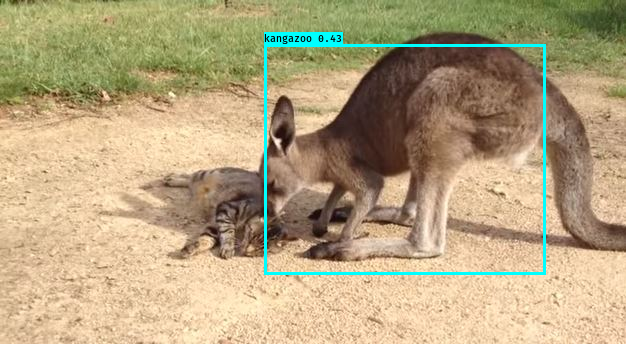

In [103]:
r_image

## 偵測影片

In [125]:
from yolo import YOLO
from timeit import default_timer as timer
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

# yolo_model = YOLO(model_path=log_dir + 'trained_weights_stage_1.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    # 透過 OpenCV 擷取影像
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video!")
        
    # 取得影像的基本資訊
#     video_FourCC = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_FourCC = cv2.VideoWriter_fourcc(*'mp4v')  # 指定 video 編碼方式(mp4)
    video_fps    = vid.get(cv2.CAP_PROP_FPS)  # 總共有多少 frames
    video_size   = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),   # 每個 frame 的寬
                    int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))  # 每個 frame 的高
    
    # 設定影像的輸出
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    
    # 初始化設定
    video_cnt = 0  
    video_playtime = []  
    
    # 迭代每個 frame 來進行影像偵測
    while True:
        return_value, frame = vid.read() # 讀取每個 frame
        video_cnt += 1 
        
        # 先把每個 frame 分開偵測，再把偵測完的 frames 串接回影片，最後輸出偵測好的影片
        if return_value == True: 
            # CV2 Image 轉換成PIL Image, 並進行圖像偵測
            image = Image.fromarray(np.uint8(frame))
#             image = Image.fromarray(frame)
            start_time = time.time() 
            # detect_image有修改過, 新增回傳box和score
            image, boxes, scores = yolo.detect_image(image)  # 直接使用 yolo.py 的 detect_image 函式
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
#             result = np.uint8(np.asarray(image)[:,:,::-1])
#             result = np.uint8(np.array(image))
            result = np.array(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
            
        else:  
            break
            
    # 釋放資源
    vid.release()  # release input video resource
    out.release()  # release output video resource
    
    return video_playtime, video_cnt

In [126]:
# 偵測 Kangaroo.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path='Data/video/Kangaroo.mp4', output_path="Data/video/Kangaroo_out1.mp4")
print('\nKangaroo.mp4 total frames:', video_cnt)  # 總共有多少 frames

avg_fps = 1/np.mean(video_playtime)
print("Kangaroo.mp4 avg fps: %.3f" % avg_fps)  # 平均 fps

(416, 416, 3)
Found 0 boxes for img
0.09779709999929764
(416, 416, 3)
Found 0 boxes for img
0.0646111000005476
(416, 416, 3)
Found 0 boxes for img
0.06771149999985937
(416, 416, 3)
Found 0 boxes for img
0.0634014000006573
(416, 416, 3)
Found 0 boxes for img
0.06359469999915746
(416, 416, 3)
Found 0 boxes for img
0.06350089999978081
(416, 416, 3)
Found 0 boxes for img
0.06426079999982903
(416, 416, 3)
Found 0 boxes for img
0.06498529999953462
(416, 416, 3)
Found 0 boxes for img
0.06427900000016962
(416, 416, 3)
Found 0 boxes for img
0.06390020000071672
(416, 416, 3)
Found 0 boxes for img
0.06371980000039912
(416, 416, 3)
Found 0 boxes for img
0.0643156000005547
(416, 416, 3)
Found 0 boxes for img
0.06389839999974356
(416, 416, 3)
Found 0 boxes for img
0.06385190000037255
(416, 416, 3)
Found 0 boxes for img
0.06292980000034731
(416, 416, 3)
Found 0 boxes for img
0.06349260000024515
(416, 416, 3)
Found 0 boxes for img
0.06427400000029593
(416, 416, 3)
Found 0 boxes for img
0.0647680000001

KeyboardInterrupt: 

In [83]:
# 偵測 Kangaroo.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path='Data/video/Raccoon.mp4', output_path="Data/video/Raccoon_out.mp4")
print('\nRaccoon.mp4 total frames:', video_cnt)  # 總共有多少 frames

avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)  # 平均 fps

(416, 416, 3)
Found 0 boxes for img
0.08110610000039742
(416, 416, 3)
Found 0 boxes for img
0.06500030000097468
(416, 416, 3)
Found 0 boxes for img
0.06685230000039155
(416, 416, 3)
Found 0 boxes for img
0.06448659999841766
(416, 416, 3)
Found 0 boxes for img
0.06384260000049835
(416, 416, 3)
Found 0 boxes for img
0.06450959999892802
(416, 416, 3)
Found 0 boxes for img
0.06381909999981872
(416, 416, 3)
Found 0 boxes for img
0.06298550000065006
(416, 416, 3)
Found 0 boxes for img
0.06394410000029893
(416, 416, 3)
Found 0 boxes for img
0.06369439999980386
(416, 416, 3)
Found 0 boxes for img
0.06451790000028268
(416, 416, 3)
Found 0 boxes for img
0.06292690000009316
(416, 416, 3)
Found 0 boxes for img
0.06478530000094906
(416, 416, 3)
Found 0 boxes for img
0.06335149999904388
(416, 416, 3)
Found 0 boxes for img
0.06426920000012615
(416, 416, 3)
Found 0 boxes for img
0.06320299999970302
(416, 416, 3)
Found 0 boxes for img
0.06387979999999516
(416, 416, 3)
Found 0 boxes for img
0.0634916999